# Setup

In [1]:
# Basics
import json
from pathlib import Path

# Data Manipulation
import pandas as pd
import numpy as np

# Feature Engineering
from sklearn.preprocessing import OrdinalEncoder as SkOrdinalEncoder 
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.encoding import CountFrequencyEncoder, OneHotEncoder
from feature_engine.selection import DropFeatures

# Machine Learning
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.base import clone
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import optuna
import joblib

# Data Visualization
import matplotlib.pyplot as plt
import yellowbrick.model_selection as ms
import yellowbrick.regressor as rg

In [2]:
# Constants
PROJECT_PATH = Path.cwd().parent.resolve()
DATA_PATH = PROJECT_PATH.joinpath("data")
DATA_RAW_PATH = DATA_PATH.joinpath("raw")
DATA_PROCESSED_PATH = DATA_PATH.joinpath("processed")
RESOURCES_PATH = PROJECT_PATH.joinpath("resources")
MODELS_PATH = PROJECT_PATH.joinpath("models")

In [3]:
# Defining plot standard parameters
plt.rcParams.update({
    "axes.labelcolor": "#595959",
    "axes.facecolor": (0, 0, 0, 0),
    "axes.grid": False,
    "axes.labelpad": 6,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.figsize": (14, 4),
    "figure.facecolor": (0, 0, 0, 0),
    "figure.dpi": 200,
    "legend.edgecolor": "#D9D9D9",
    "legend.borderaxespad": 0,
    "legend.framealpha": None,
    "legend.fontsize": 8,
    "legend.loc": "upper right",
    "legend.title_fontsize": 9,
    "text.color": "#595959",
    "xtick.color": "#D9D9D9",
    "xtick.labelcolor": "#595959",
    "ytick.color": "#D9D9D9",
    "ytick.labelcolor": "#595959"
})

In [4]:
# Metadata
with open(DATA_RAW_PATH.joinpath("raw_data_dict.json")) as json_file:
    metadata = json.load(json_file)

dtype_mapping = {
    item["nome_do_campo_antes_limpeza"]: item["tipo"]
    for item in metadata
    if item["tipo"] != "datetime64[ns]"
}

# Pre-Processing

In [5]:
df = (
    pd
    .read_parquet(DATA_PROCESSED_PATH.joinpath("deliveries.parquet"), engine="pyarrow")
    .assign(
        marca_da_loja=lambda _df: _df["marca_da_loja"].astype("category"),
        nome_da_loja=lambda _df: _df["nome_da_loja"].astype("category"),
    ) 
)

In [6]:
# Encoders
shift_encoder = SklearnTransformerWrapper(transformer=SkOrdinalEncoder(categories=[["MANHA", "ALMOCO", "TARDE", "JANTAR", "CEIA", "MADRUGADA"]]), variables=["turno"])
priority_encoder = SklearnTransformerWrapper(transformer=SkOrdinalEncoder(categories=[["PADRAO", "RAPIDA"]]), variables=["prioridade_do_pedido"])
brand_and_store_encoder = CountFrequencyEncoder(encoding_method="count", variables=["marca_da_loja", "nome_da_loja"])
logistic_service_encoder = OneHotEncoder(drop_last=True, variables=["servico_logistico"])

In [7]:
# Pipeline
preprocessing_pipeline = Pipeline(steps=[
    ("datetitme_dropper", DropFeatures(features_to_drop=["data_e_hora_do_pedido"])),
    ("shift_encoder", shift_encoder),
    ("priority_encoder", priority_encoder),
    ("brand_and_store_encoder", brand_and_store_encoder),
    ("logistic_service_encoder", logistic_service_encoder),
])

In [8]:
# Split
X = df.drop(columns=["tempo_da_entrega_realizada_min"])
y = df["tempo_da_entrega_realizada_min"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,  # Arrays
    test_size=0.2,
    random_state=42,
    shuffle=True
)

kfold = KFold(n_splits=3, shuffle=True)

In [9]:
def get_cv_results(estimator, cv, X_train, y_train, X_test, y_test):
    """
    Perform cross-validation and return results as DataFrame.
    
    Parameters:
    -----------
    estimator : sklearn Pipeline
        The pipeline with preprocessing steps and regressor
    cv : cross-validation generator
        Cross-validation strategy (e.g., KFold)
    X_train : array-like
        Training features
    y_train : array-like
        Training target
    X_test : array-like
        Test features
    y_test : array-like
        Test target
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with MAE and RMSE metrics for train, validation and test sets
    """
    # Get estimator name from last step of pipeline
    estimator_name = estimator.steps[-1][0]
    
    # Cross-validation on training set
    cv_results = cross_validate(
        estimator=estimator,
        X=X_train,
        y=y_train,
        scoring=["neg_mean_squared_error", "neg_mean_absolute_error"],
        cv=cv,
        return_train_score=True,
    )
    
    # Extract train scores from CV
    mae_train_cv = -cv_results["train_neg_mean_absolute_error"]
    rmse_train_cv = np.sqrt(-cv_results["train_neg_mean_squared_error"])
    
    # Extract validation scores from CV
    mae_val_cv = -cv_results["test_neg_mean_absolute_error"]
    rmse_val_cv = np.sqrt(-cv_results["test_neg_mean_squared_error"])
    
    # Clone estimator and fit on training data to evaluate on test set
    estimator_full = clone(estimator)
    estimator_full.fit(X=X_train, y=y_train)
    y_pred_test = estimator_full.predict(X=X_test)
    mae_test = mean_absolute_error(y_true=y_test, y_pred=y_pred_test)
    rmse_test = np.sqrt(np.mean((y_test - y_pred_test) ** 2))
    
    # Create result DataFrame
    result = pd.DataFrame({
        "estimator": [estimator_name],
        "mae_train": [f"{mae_train_cv.mean():.2f} ± {mae_train_cv.std():.2f}"],
        "mae_val": [f"{mae_val_cv.mean():.2f} ± {mae_val_cv.std():.2f}"],
        "mae_test": [f"{mae_test:.2f}"],
        "rmse_train": [f"{rmse_train_cv.mean():.2f} ± {rmse_train_cv.std():.2f}"],
        "rmse_val": [f"{rmse_val_cv.mean():.2f} ± {rmse_val_cv.std():.2f}"],
        "rmse_test": [f"{rmse_test:.2f}"]
    })
    
    return result, estimator_full


def plot_learning_curve(estimator, cv, X_train, y_train):
    """
    Create a learning curve plot.
    
    Parameters:
    -----------
    estimator : sklearn Pipeline
        The pipeline with preprocessing steps and regressor
    cv : cross-validation generator
        Cross-validation strategy (e.g., KFold)
    X_train : array-like
        Training features
    y_train : array-like
        Training target
        
    Returns:
    --------
    matplotlib.figure.Figure
        Learning curve figure
    """
    # Get estimator name from last step of pipeline
    estimator_name = estimator.steps[-1][0]
    
    # Create learning curve using Yellowbrick
    lc_viz = ms.learning_curve(
        estimator=estimator,
        X=X_train,
        y=y_train,
        cv=cv,
        scoring="neg_mean_absolute_error",
        shuffle=True,
        random_state=42,
        show=False,
    )
    
    # Close the figure created by Yellowbrick to prevent it from displaying
    plt.close(lc_viz.ax.figure)
    
    # Extract sizes and scores from the visualizer
    train_sizes = np.array(lc_viz.train_sizes_)
    # lc_viz.train_scores_ and viz.test_scores_ are negative MAE because we used neg_mean_absolute_error
    train_scores = -np.array(lc_viz.train_scores_)
    test_scores = -np.array(lc_viz.test_scores_)
    
    # Compute mean and std across folds
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)
    
    # Create learning curve plot
    fig_learning, ax_learning = plt.subplots()
    
    # Plot the computed learning curve lines with shaded std regions
    ax_learning.plot(train_sizes, train_mean, marker="o", color="tab:blue", label="Train MAE")
    ax_learning.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="tab:blue")
    
    ax_learning.plot(train_sizes, test_mean, marker="o", color="tab:orange", label="Validation MAE")
    ax_learning.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="tab:orange")
    
    # Annotate each point with its MAE value (train above, test below)
    for x, y_train, y_test in zip(train_sizes, train_mean, test_mean):
        ax_learning.annotate(f"{y_train:.2f}", xy=(x, y_train), xytext=(0, 6), textcoords="offset points", ha="center", va="bottom", fontsize=8, color="tab:blue")
        ax_learning.annotate(f"{y_test:.2f}", xy=(x, y_test), xytext=(0, -10), textcoords="offset points", ha="center", va="top", fontsize=8, color="tab:orange")
    
    # Labels and title
    ax_learning.set_xlabel("Training set size")
    ax_learning.set_ylabel("MAE")
    ax_learning.set_title(f"Learning Curve ({estimator_name.replace('_', ' ').title()})")
    ax_learning.legend()
    
    return fig_learning


def plot_residuals(estimator, X_train, y_train, X_test, y_test):
    """
    Create a residuals plot.
    
    Parameters:
    -----------
    estimator : sklearn Pipeline
        The pipeline with preprocessing steps and regressor
    X_train : array-like
        Training features
    y_train : array-like
        Training target
    X_test : array-like
        Test features
    y_test : array-like
        Test target
        
    Returns:
    --------
    matplotlib.figure.Figure
        Residuals plot figure
    """
    fig_residuals, ax_residuals = plt.subplots()
    res_viz = rg.residuals_plot(
        estimator=estimator,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        ax=ax_residuals,
        is_fitted=False,
    )
    ax_residuals.set_title(f"Residuals Plot ({estimator.steps[-1][0].replace('_', ' ').title()})")

    return res_viz.ax.figure


def evaluate_model(estimator, cv, X_train, y_train, X_test, y_test):
    """
    Evaluate a model using cross-validation and return results as DataFrame, learning curve chart, residuals histogram, and fitted model.
    
    Parameters:
    -----------
    estimator : sklearn Pipeline
        The pipeline with preprocessing steps and regressor
    cv : cross-validation generator
        Cross-validation strategy (e.g., KFold)
    X_train : array-like
        Training features
    y_train : array-like
        Training target
    X_test : array-like
        Test features
    y_test : array-like
        Test target
        
    Returns:
    --------
    tuple
        (pd.DataFrame, matplotlib.figure.Figure, matplotlib.figure.Figure, fitted_model) containing metrics, learning curve chart, residuals histogram, and fitted model
    """
    result, fitted_model = get_cv_results(estimator, cv, X_train, y_train, X_test, y_test)
    fig_learning = plot_learning_curve(estimator, cv, X_train, y_train)
    fig_residuals = plot_residuals(estimator, X_train, y_train, X_test, y_test)
    
    return result, fig_learning, fig_residuals, fitted_model

# Modelling

## Dummy Regressor

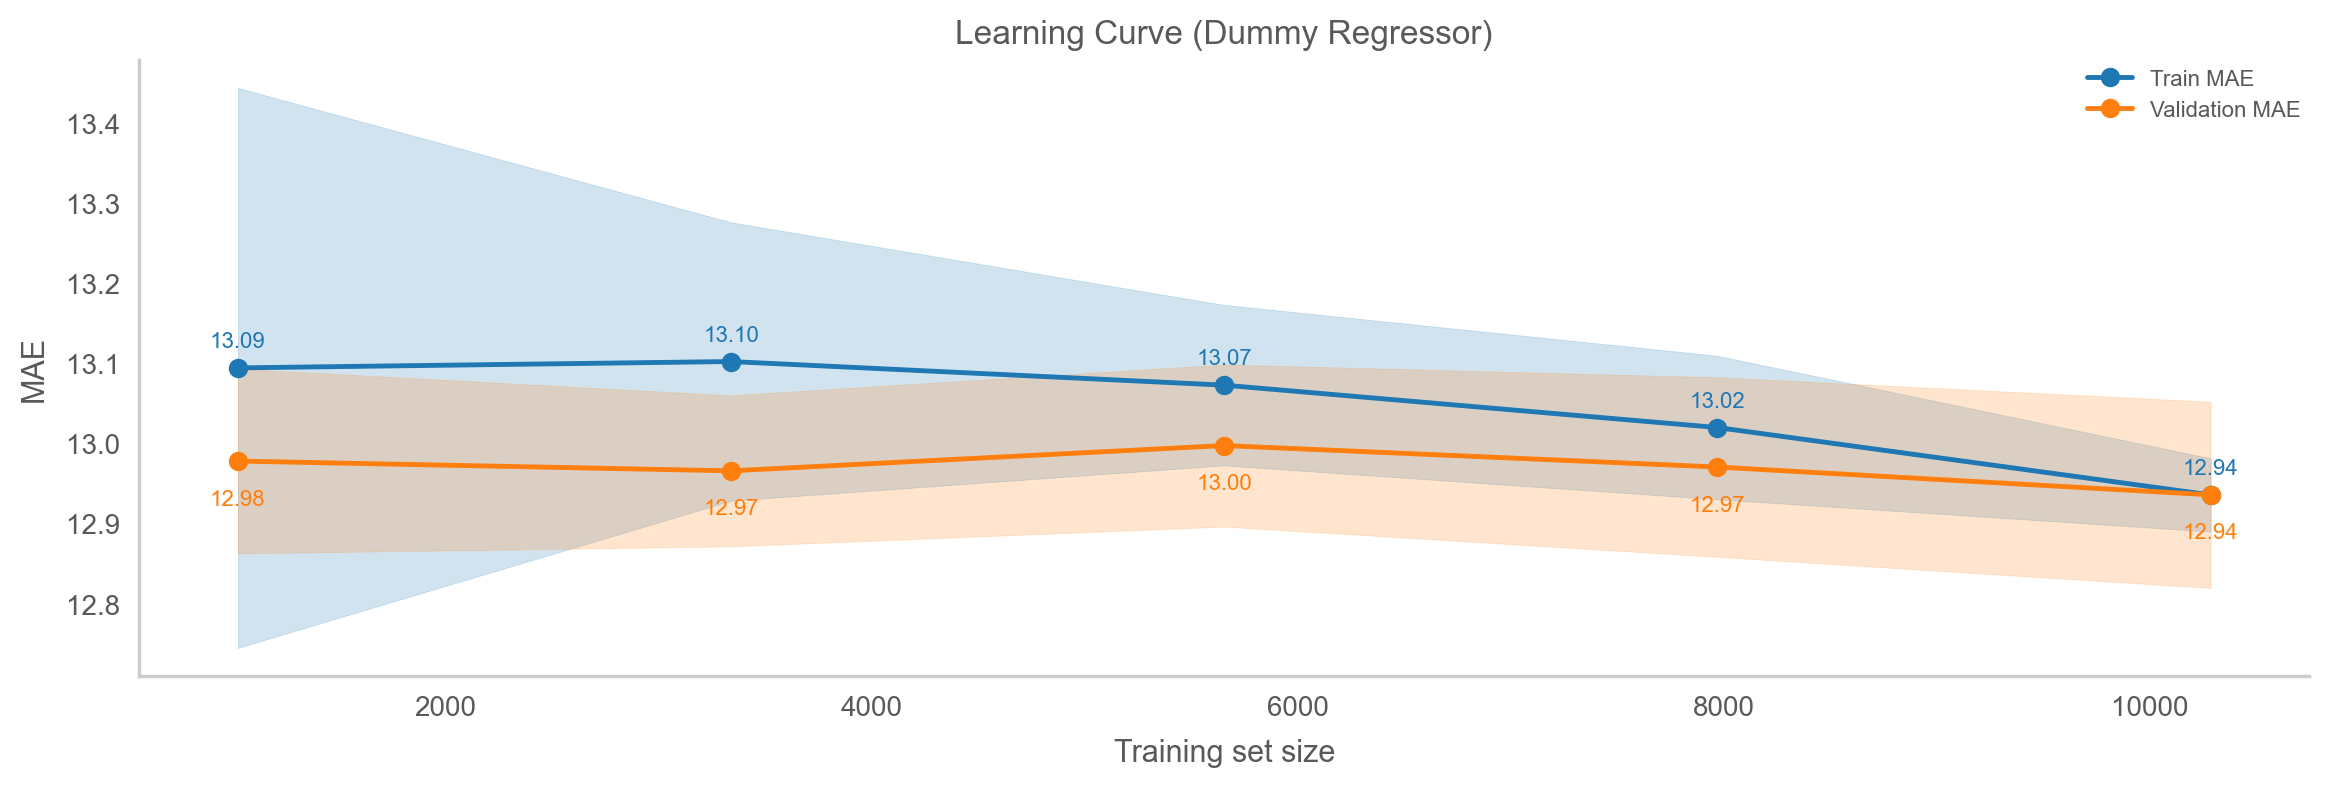

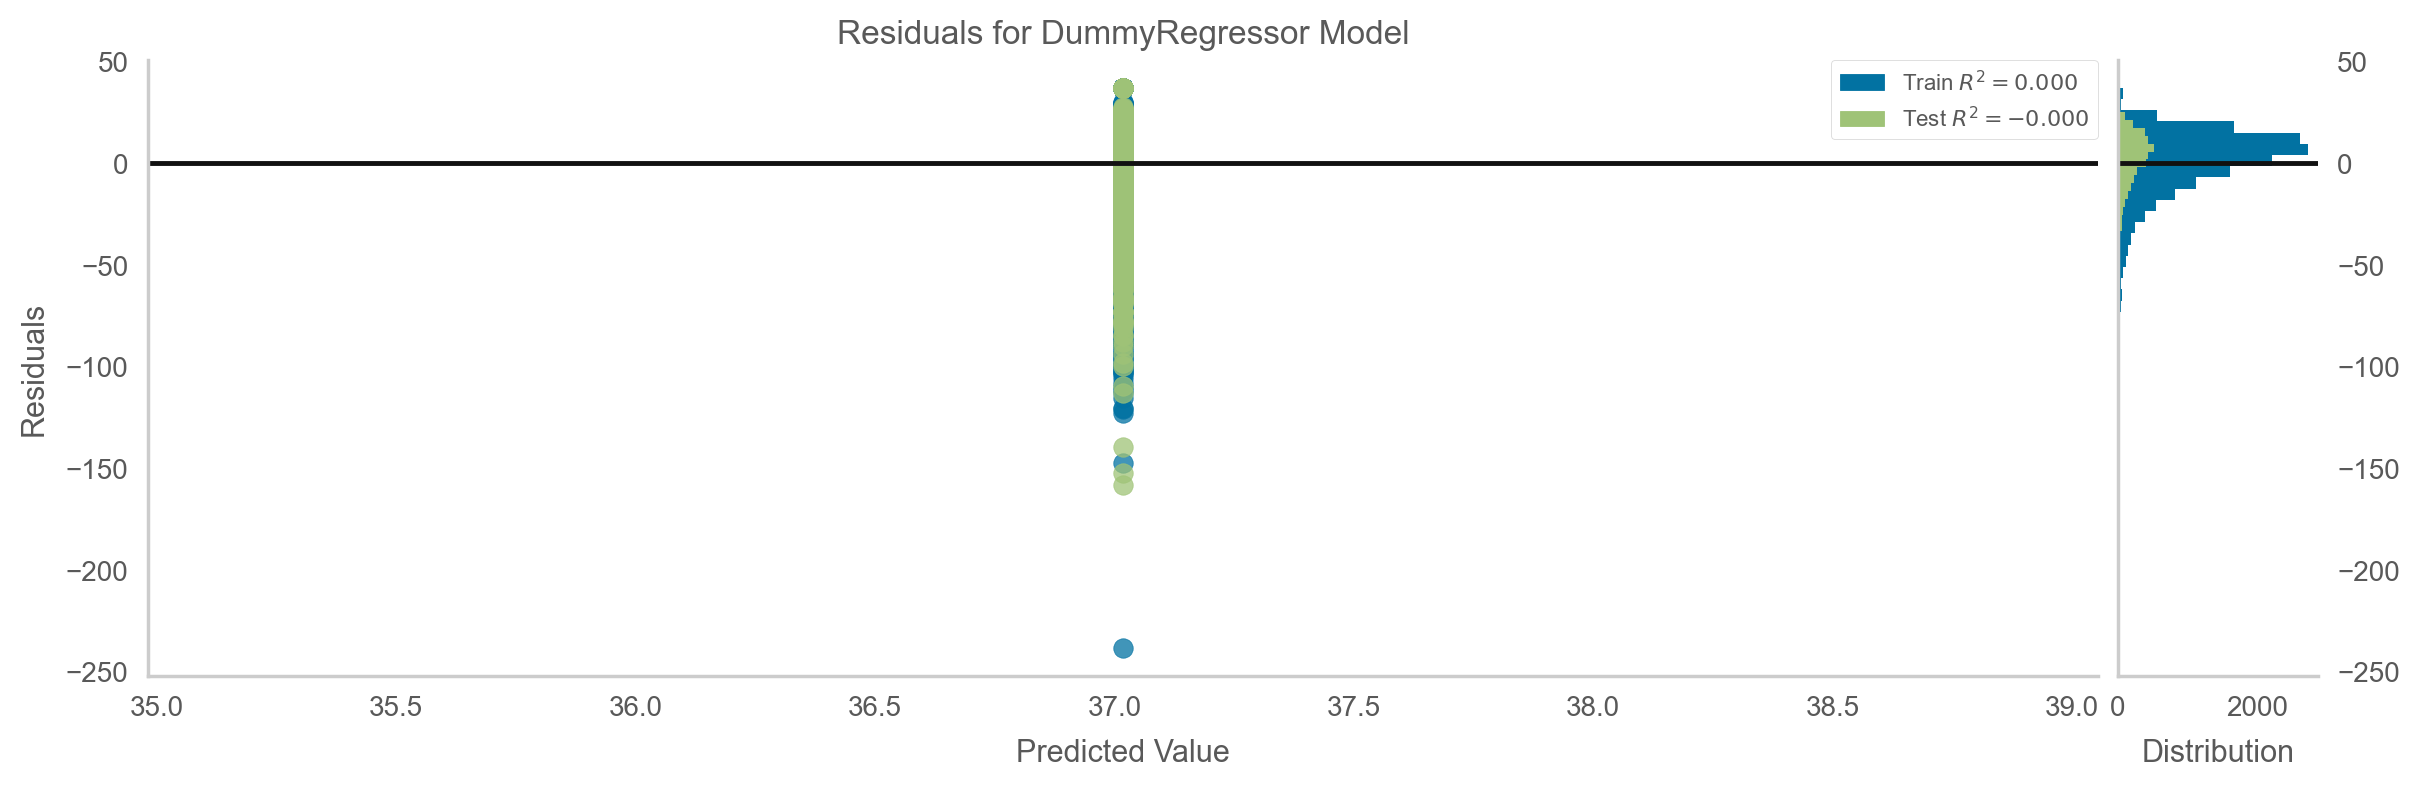

In [10]:
dummy_pipeline = Pipeline(preprocessing_pipeline.steps + [("dummy_regressor", DummyRegressor(strategy="mean"))])
df_dummy, fig_learning_dummy, fig_residuals_dummy, dummy_model = evaluate_model(
    estimator=dummy_pipeline, 
    cv=kfold, 
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)

fig_learning_dummy.savefig(RESOURCES_PATH.joinpath("visualizations", "lc_dummy.png"))
fig_residuals_dummy.savefig(RESOURCES_PATH.joinpath("visualizations", "rp_dummy.png"))

plt.show(fig_learning_dummy)

## XGBoost

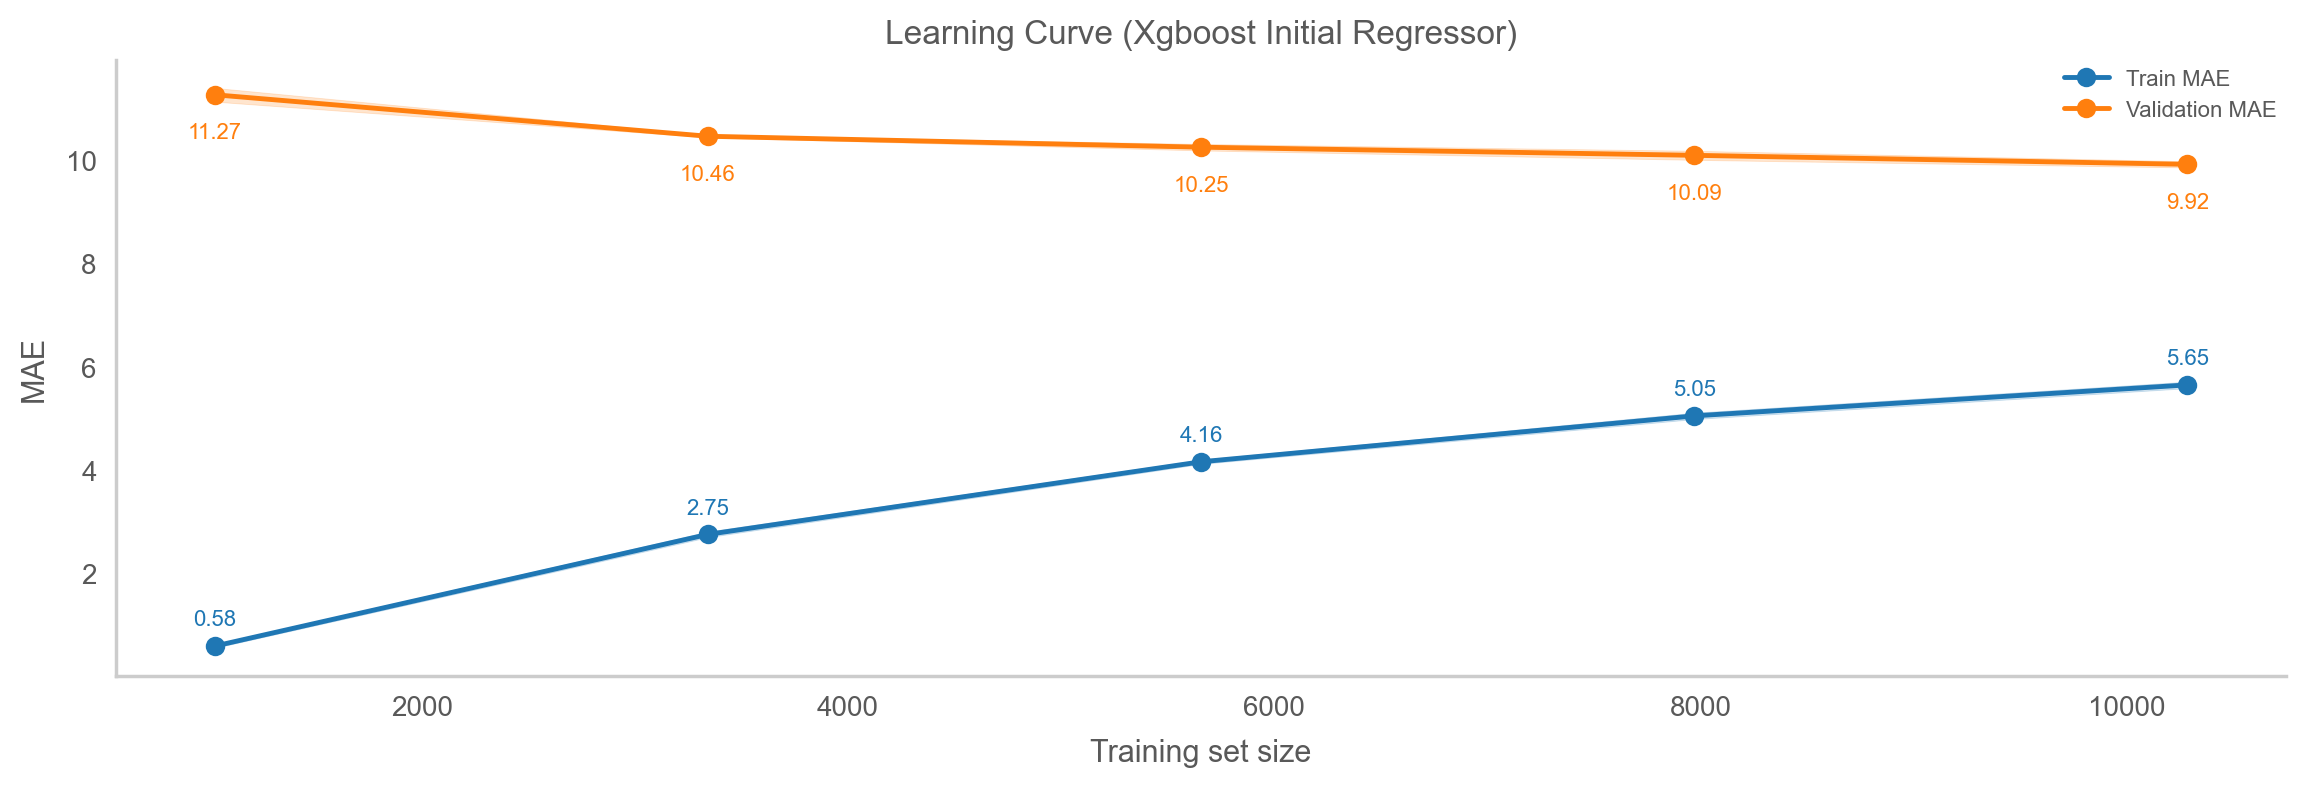

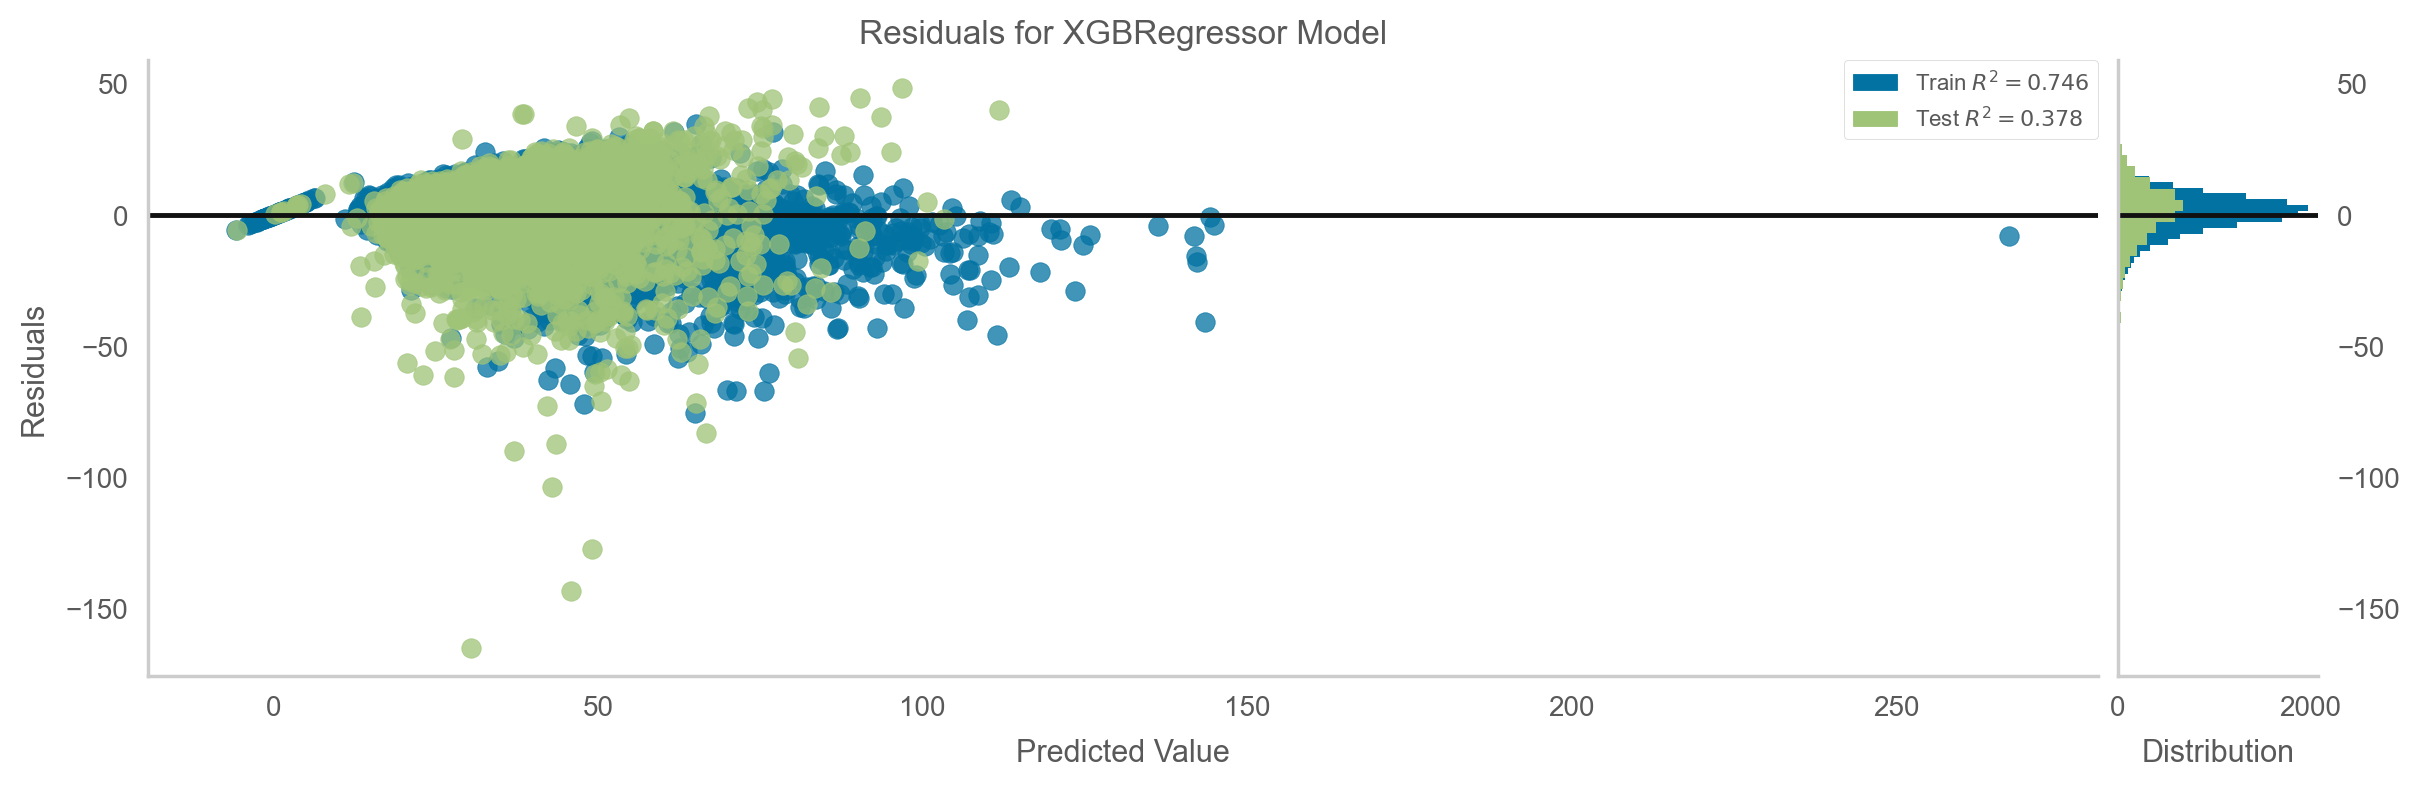

In [11]:
xgb_initial_pipe = Pipeline(preprocessing_pipeline.steps + [("xgboost_initial_regressor", XGBRegressor(random_state=42, n_estimators=100))])
df_xgb_initial, fig_learning_xgb, fig_residuals_xgb, xgb_initial_model = evaluate_model(
    estimator=xgb_initial_pipe,
    cv=kfold, 
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)

fig_learning_xgb.savefig(RESOURCES_PATH.joinpath("visualizations", "lc_xgb_initial.png"))
fig_residuals_xgb.savefig(RESOURCES_PATH.joinpath("visualizations", "rp_xgb_initial.png"))

plt.show()

## Optimized XGBoost

In [12]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "gamma": trial.suggest_float("gamma", 0, 5.0),
        "alpha": trial.suggest_float("alpha", 0, 10.0),
        "lambda": trial.suggest_float("lambda", 1, 10.0),
        "verbosity": 0,
        "random_state": 42,
    }

    # Create a temporary pipeline for this trial
    temp_pipeline = Pipeline(preprocessing_pipeline.steps + [("xgboost", XGBRegressor(**params))])
    
    # Use cross-validation on training data
    cv_results = cross_validate(
        estimator=temp_pipeline,
        X=X_train,
        y=y_train,
        scoring="neg_mean_absolute_error",
        cv=kfold,
        return_train_score=False,
    )
    
    mae = -cv_results["test_score"].mean()
    return mae

In [13]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-11-12 14:31:40,518] A new study created in memory with name: no-name-5c4eaeb9-057b-4f2a-a18c-87d5cab092a6
[I 2025-11-12 14:31:41,170] Trial 0 finished with value: 9.952186266581217 and parameters: {'n_estimators': 102, 'learning_rate': 0.027103171834231245, 'max_depth': 6, 'subsample': 0.5183121679170337, 'colsample_bytree': 0.5901812311153296, 'min_child_weight': 11, 'gamma': 1.6979455565023938, 'alpha': 7.931056830132088, 'lambda': 9.785584327611339}. Best is trial 0 with value: 9.952186266581217.
[I 2025-11-12 14:31:44,793] Trial 1 finished with value: 12.329166730244955 and parameters: {'n_estimators': 438, 'learning_rate': 0.0012949860485901967, 'max_depth': 10, 'subsample': 0.2769985683214279, 'colsample_bytree': 0.12543362330810573, 'min_child_weight': 17, 'gamma': 4.987228842587571, 'alpha': 9.51431727144541, 'lambda': 2.9152622323756936}. Best is trial 0 with value: 9.952186266581217.
[I 2025-11-12 14:31:50,005] Trial 2 finished with value: 9.837082227071127 and parame

In [14]:
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor MAE: {study.best_value}")

Melhores hiperparâmetros: {'n_estimators': 1481, 'learning_rate': 0.007483087651577345, 'max_depth': 8, 'subsample': 0.8320533126156157, 'colsample_bytree': 0.683919134040682, 'min_child_weight': 13, 'gamma': 1.086386431923974, 'alpha': 2.5496863722848557, 'lambda': 2.4571646560366918}
Melhor MAE: 9.335972785949707


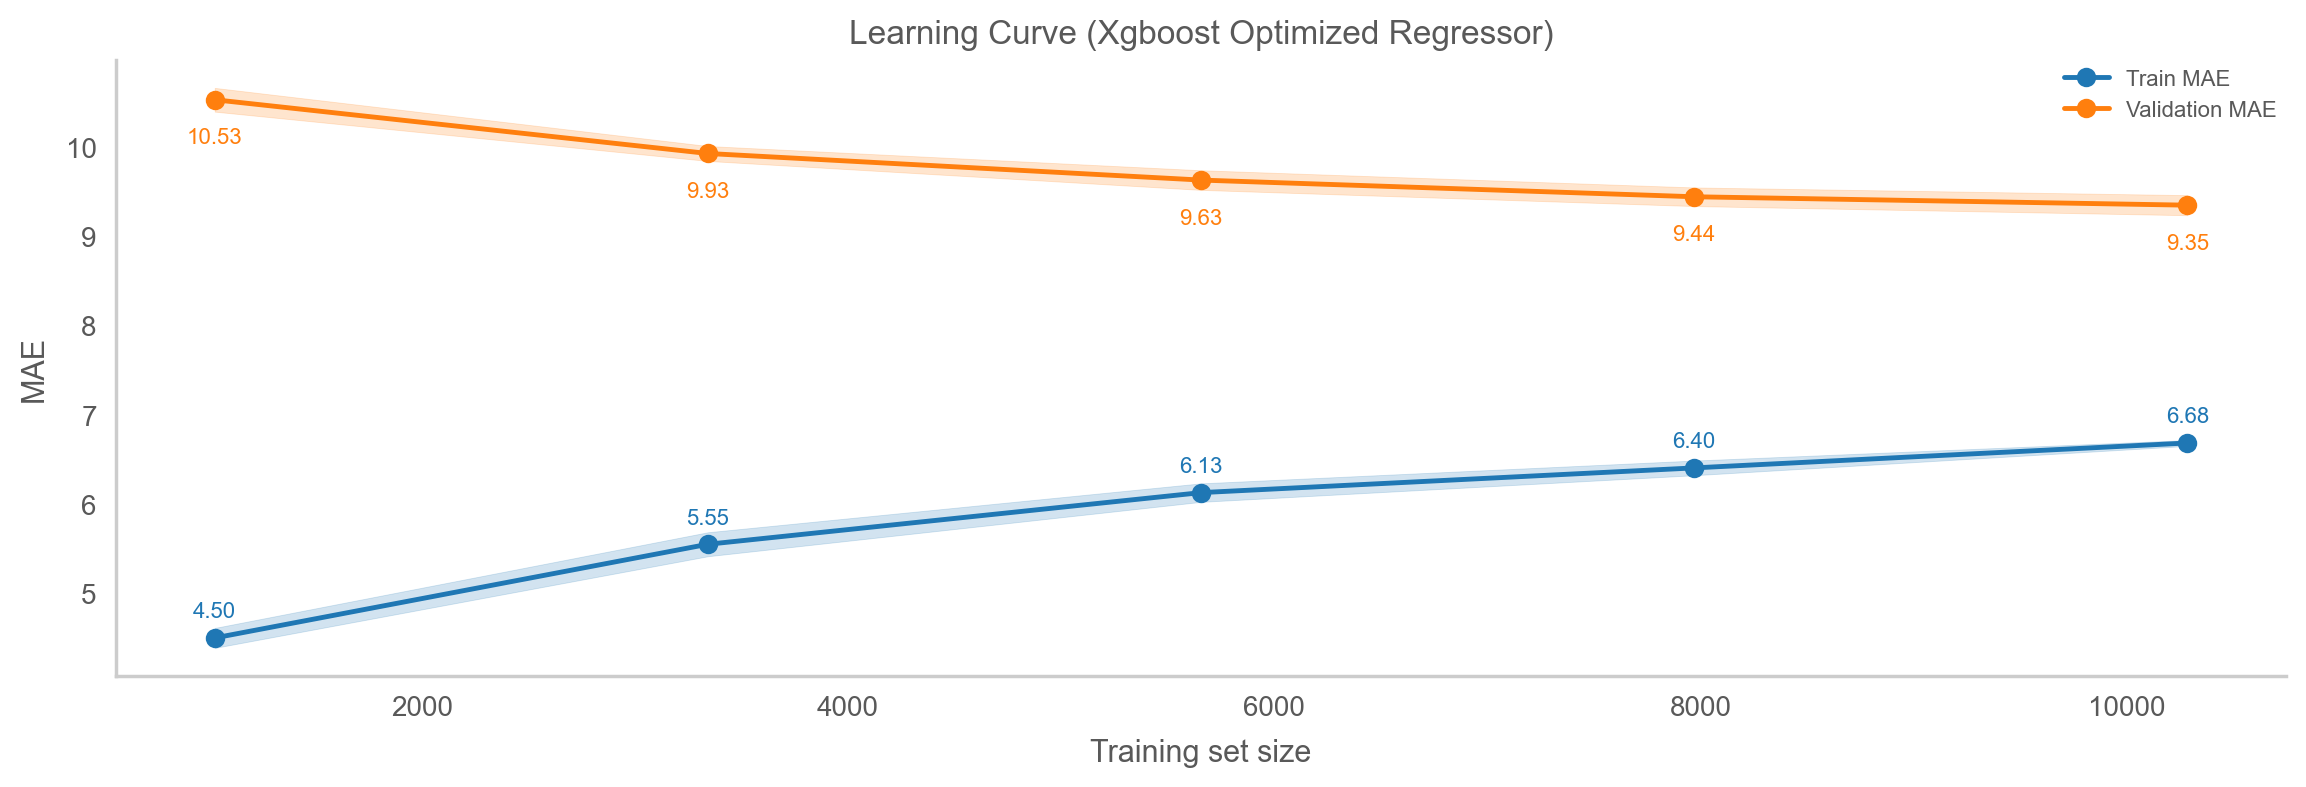

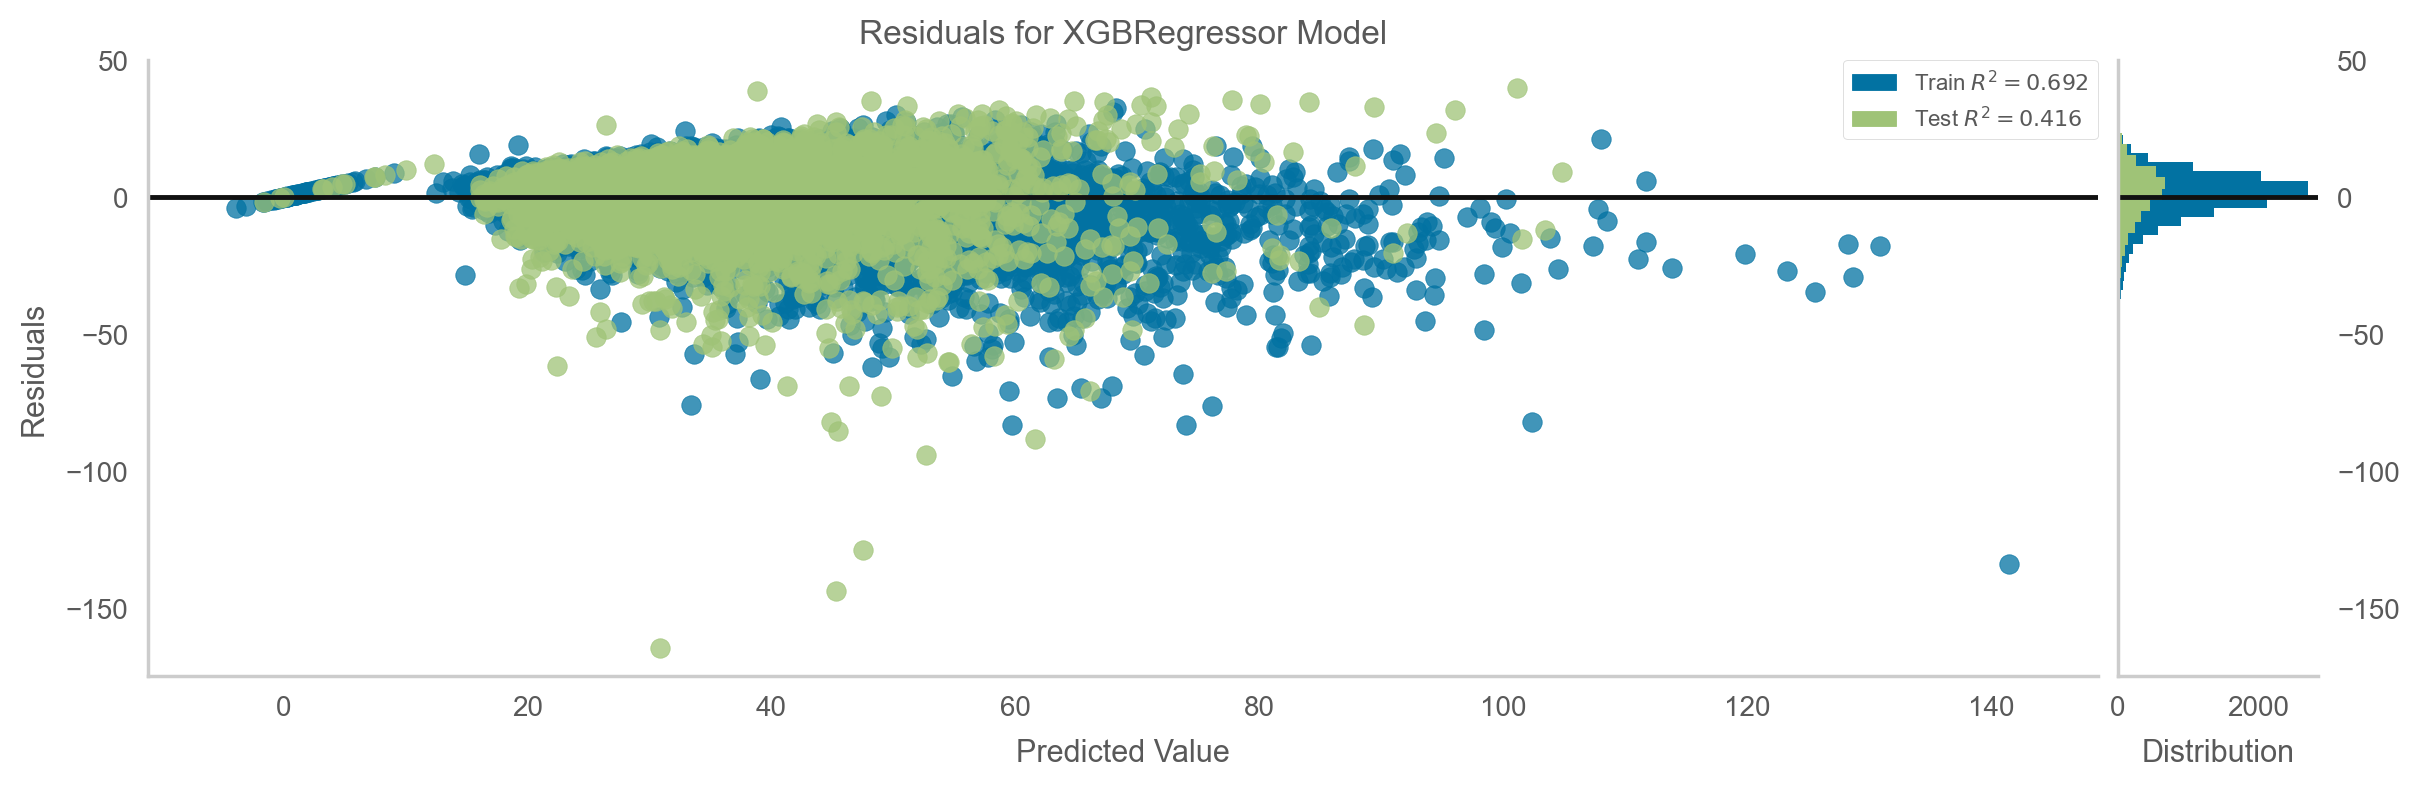

In [15]:
model = Pipeline(preprocessing_pipeline.steps + [("xgboost_optimized_regressor", XGBRegressor(**study.best_params))])

df_xgb_optimized, fig_learning_xgb_optimized, fig_residuals_xgb_optimized, xgb_optimized_model = evaluate_model(
    estimator=model,
    cv=kfold, 
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)

fig_learning_xgb_optimized.savefig(RESOURCES_PATH.joinpath("visualizations", "lc_xgb_optimized.png"))
fig_residuals_xgb_optimized.savefig(RESOURCES_PATH.joinpath("visualizations", "rp_xgb_optimized.png"))

plt.show()

# Results

In [16]:
df_results = pd.concat([df_dummy, df_xgb_initial, df_xgb_optimized], ignore_index=True)
display(df_results)

,estimator,mae_train,mae_val,mae_test,rmse_train,rmse_val,rmse_test
0,dummy_regressor,12.94 ± 0.03,12.94 ± 0.05,12.81,17.88 ± 0.10,17.88 ± 0.19,18.00
1,xgboost_initial_regressor,5.62 ± 0.08,9.88 ± 0.06,9.83,7.73 ± 0.11,14.09 ± 0.30,14.19
2,xgboost_optimized_regressor,6.70 ± 0.08,9.37 ± 0.07,9.49,9.40 ± 0.15,13.42 ± 0.24,13.75


# Exporting Model and Data

In [17]:
joblib.dump(value=preprocessing_pipeline, filename=MODELS_PATH.joinpath("preprocessing_pipeline.pkl"))
joblib.dump(value=xgb_optimized_model, filename=MODELS_PATH.joinpath("xgb_optimized_model.pkl"))

['/Users/ewerthon/Documents/Materiais/data_science/mestrado/reconhecimento_de_padroes/delivery-time-prediction/models/xgb_optimized_model.pkl']

In [18]:
df_results.to_parquet(
    path=DATA_PROCESSED_PATH.joinpath("results.parquet"),
    engine="pyarrow",
    index=False,
)

X_train.to_parquet(
    path=DATA_PROCESSED_PATH.joinpath("X_train.parquet"),
    engine="pyarrow",
    index=False,
)
pd.DataFrame(y_train).to_parquet(
    path=DATA_PROCESSED_PATH.joinpath("y_train.parquet"),
    engine="pyarrow",
    index=False,
)
X_test.to_parquet(
    path=DATA_PROCESSED_PATH.joinpath("X_test.parquet"),
    engine="pyarrow",
    index=False,
)
pd.DataFrame(y_test).to_parquet(
    path=DATA_PROCESSED_PATH.joinpath("y_test.parquet"),
    engine="pyarrow",
    index=False,
)